In [1]:
include("D:\\Julia\\dqmc_fsj\\lattice_model.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_parameters.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_fields.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_matrix_cdw_channel.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_stable.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_eqlt_greens.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_update.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_helper.jl")
include("D:\\Julia\\dqmc_fsj\\dqmc_ueqlt_greens.jl")

get_uneqlt_greens (generic function with 1 method)

In [41]:
beta = 8.0
mu = 0.0

# for Lx = 8
Lx = 8
Ly = 8
# for Lx = 6
# Lx = 6
# Ly = 6

t = 1.0
Hubbard_U = 4.0

thermal_sweeps = 3000
meas_sweeps = 3000

tri_lat = Triangular_Lattice(Lx, Ly)
double_lattice_array = zeros(Int64, 2 * Lx, 2 * Ly)
@inbounds begin
    @turbo for i = 1:2, j = 1:2
        for site_x = 1:Lx, site_y = 1:Lx
            double_lattice_array[Lx*(i-1)+site_x, Lx*(j-1)+site_y] = tri_lat.Lattice[site_x, site_y]     
        end
    end
end

dims = stack.dims
occs_meas = zeros(Float64, dims)
cdc_meas = zeros(Float64, (Lx, Ly))  # 存储实空间的site-site pair

tri_model = Single_Band_Hubbard_Model(t=t, U=Hubbard_U, mu=mu, lattice=tri_lat)
parameters = dqmc_parameters(beta=beta)
hs_field = HSField_CDW(delta_tau=parameters.delta_tau, slice_num=parameters.slices, n_sites=tri_model.lattice.sites, U=tri_model.Hubbard_U)
stack = dqmc_matrices_stack_real_qr(tri_model, parameters)

build_udt_stacks_modified!(hs_field, stack)
copyto!(stack.u_stack[1], I)
stack.d_stack[1] .= one(Float64)
copyto!(stack.t_stack[1], I)

# 热化
thermalization_sweeps(hs_field, stack, thermal_sweeps)

# 测量
bins_occs = zeros(Float64, (dims, meas_sweeps))
bins_cdc = zeros(Float64, (Lx, Ly, meas_sweeps))

for sweep_idx in 1:meas_sweeps
    sweep_up_local_modified!(hs_field, stack)
    sweep_down_local_modified!(hs_field, stack)

    # 先计算平均占据数
    stack.current_range = 1
    get_greens_temp_modified!(stack)
    for site = 1:dims
        bins_occs[site, sweep_idx] = 2 * (1 - stack.greens_temp[site,site]) # 2来自于自旋简并
    end
    
    # 再计算cdc:由于对称性，我们可以把计算量减小一倍
    for m = 0:Lx-1, n = 0:Ly-1  # (m, n)表示两个site之间的矢量
        cdc_00 = zero(Float64)
        for site1_x = 1:Lx, site1_y = 1:Ly # (site1_x, site1_y)表示site1的坐标
            site1 = double_lattice_array[site1_x, site1_y]
            site2 = double_lattice_array[site1_x + m, site1_y + n]
            
            cdc_00 += 4 * (1 - stack.greens_temp[site1, site1]) * (1 - stack.greens_temp[site2, site2])
            cdc_00 -= 2 * stack.greens_temp[site1, site2] * stack.greens_temp[site2, site1]
        end
        
        if m == 0 && n == 0
            for site = 1:dims
                cdc_00 += 2 * stack.greens_temp[site, site]
            end
        end
        
        bins_cdc[m+1,n+1, sweep_idx] = cdc_00
    end
    
end

In [42]:
bins_occs_av_test = zeros(Float64, meas_sweeps)
for sweep_index in 1:meas_sweeps
    for site = 1:dims
        bins_occs_av_test[sweep_index] += bins_occs[site, sweep_index]
    end
    bins_occs_av_test[sweep_index] = bins_occs_av_test[sweep_index] / dims
end

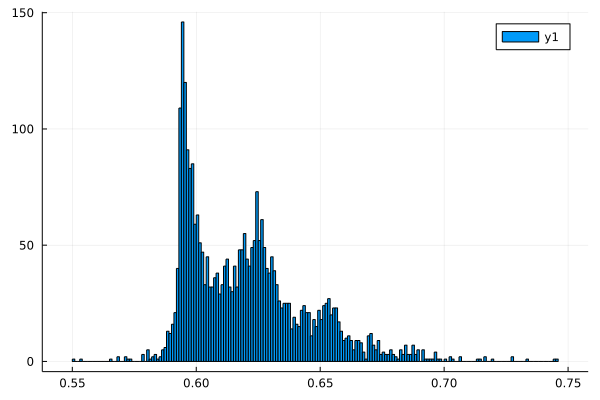

In [43]:
using Plots
histogram(bins_occs_av_test, bins = 200)

In [46]:
for site = 1:dims
    occs_meas[site] = sum(bins_occs[site,:]) / meas_sweeps # 2来自于自旋简并
end

for site_x = 1:Lx, site_y = 1:Ly  # (m, n)表示两个site之间的矢量
    cdc_meas[site_x, site_y] = sum(bins_cdc[site_x, site_y, :]) / (meas_sweeps * dims)
end

display(cdc_meas)
display(occs_meas)

8×8 Matrix{Float64}:
 0.918209  0.308568  0.385355  0.386725  …  0.386725  0.385355  0.308568
 0.307851  0.307768  0.391197  0.377661     0.384341  0.37858   0.39197
 0.386329  0.390714  0.385214  0.3781       0.384073  0.385494  0.37738
 0.385986  0.378029  0.378677  0.386468     0.384678  0.384762  0.384844
 0.378266  0.384072  0.38521   0.384002     0.384002  0.38521   0.384072
 0.385986  0.384844  0.384762  0.384678  …  0.386468  0.378677  0.378029
 0.386329  0.37738   0.385494  0.384073     0.3781    0.385214  0.390714
 0.307851  0.39197   0.37858   0.384341     0.377661  0.391197  0.307768

64-element Vector{Float64}:
 0.6352254384250184
 0.6069084995100873
 0.6213579297105337
 0.6292779401406302
 0.613156721759677
 0.6279686085482196
 0.6287362790672435
 0.5987626480064395
 0.6268092449713039
 0.6335315383648656
 0.6250531296025518
 0.6494794107489154
 0.6119614800522156
 ⋮
 0.6141799356456946
 0.6261609540019957
 0.6387427817875345
 0.6128233865943856
 0.613330145252176
 0.635607562874931
 0.5983778096018753
 0.6085900585966029
 0.6197349578428342
 0.617115502753325
 0.6240455209491532
 0.6218146882369968

In [47]:
# 快速傅里叶变换
# 默认是取与格点数一样多的点，这也是最高的“分辨率”了
if Lx % 2 == 0 
    qx_map = zeros(Float64, (Lx+1, Ly+1))
    qy_map = zeros(Float64, (Lx+1, Ly+1))
    q_center = [Int(floor((Lx + 1) / 2)) + 1, Int(floor((Ly + 1) / 2)) + 1]
else
    qx_map = zeros(Float64, (Lx, Ly))
    qy_map = zeros(Float64, (Lx, Ly))
    q_center = [Int(Lx / 2), Int(Ly / 2)]
end

qx_points = size(qx_map)[1]
qy_points = size(qx_map)[2]
for qx = 1:qx_points, qy = 1:qy_points
    qx_map[qx, qy] = (qx - q_center[1]) / Lx
    qy_map[qx, qy] = (qy - q_center[2]) / Ly
end

display(qx_map)
display(qy_map)

9×9 Matrix{Float64}:
 -0.5    -0.5    -0.5    -0.5    -0.5    -0.5    -0.5    -0.5    -0.5
 -0.375  -0.375  -0.375  -0.375  -0.375  -0.375  -0.375  -0.375  -0.375
 -0.25   -0.25   -0.25   -0.25   -0.25   -0.25   -0.25   -0.25   -0.25
 -0.125  -0.125  -0.125  -0.125  -0.125  -0.125  -0.125  -0.125  -0.125
  0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
  0.125   0.125   0.125   0.125   0.125   0.125   0.125   0.125   0.125
  0.25    0.25    0.25    0.25    0.25    0.25    0.25    0.25    0.25
  0.375   0.375   0.375   0.375   0.375   0.375   0.375   0.375   0.375
  0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5

9×9 Matrix{Float64}:
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5
 -0.5  -0.375  -0.25  -0.125  0.0  0.125  0.25  0.375  0.5

In [48]:
cdc_meas_fft = zeros(ComplexF64, (qx_points, qy_points))
for (qx_index, qx) in enumerate(qx_map[:,1]), (qy_index, qy) in enumerate(qy_map[1,:])
    for n1 = 0:Lx - 1, n2 = 0:Ly - 1
        phase_angle = 2 * pi * (qx * n1 + qy * n2)
        cdc_meas_fft[qx_index, qy_index] += exp(- im * phase_angle) * cdc_meas[n1 + 1, n2 + 1]
    end
    cdc_meas_fft[qx_index, qy_index] = cdc_meas_fft[qx_index, qy_index] / dims
end

# 必须算出来的结果是虚部为零才是对的
display(real(cdc_meas_fft))
display(cdc_meas_fft)

9×9 Matrix{Float64}:
 0.0107508  0.010899    0.0101808   …  0.0101808   0.010899    0.0107508
 0.0107006  0.0128667   0.0128009      0.00778784  0.00923811  0.0107006
 0.0100208  0.0127726   0.0100928      0.00578557  0.00780934  0.0100208
 0.0107297  0.0107501   0.0078688      0.00526921  0.00780722  0.0107297
 0.0108031  0.00928468  0.00581607     0.00581607  0.00928468  0.0108031
 0.0107297  0.00780722  0.00526921  …  0.0078688   0.0107501   0.0107297
 0.0100208  0.00780934  0.00578557     0.0100928   0.0127726   0.0100208
 0.0107006  0.00923811  0.00778784     0.0128009   0.0128667   0.0107006
 0.0107508  0.010899    0.0101808      0.0101808   0.010899    0.0107508

9×9 Matrix{ComplexF64}:
 0.0107508+4.11436e-17im  …  0.0107508-4.44594e-20im
 0.0107006-3.07913e-17im     0.0107006-2.60209e-18im
 0.0100208+0.0im             0.0100208+1.73472e-18im
 0.0107297-5.20417e-18im     0.0107297+8.67362e-19im
 0.0108031+2.11666e-17im     0.0108031-2.11666e-17im
 0.0107297-8.67362e-19im  …  0.0107297+5.20417e-18im
 0.0100208-1.73472e-18im     0.0100208+0.0im
 0.0107006+2.60209e-18im     0.0107006+3.07913e-17im
 0.0107508+4.44594e-20im     0.0107508-4.11436e-17im

In [52]:
cdc_meas_fft[q_center[1],q_center[2]]

0.38514012470322767 + 0.0im

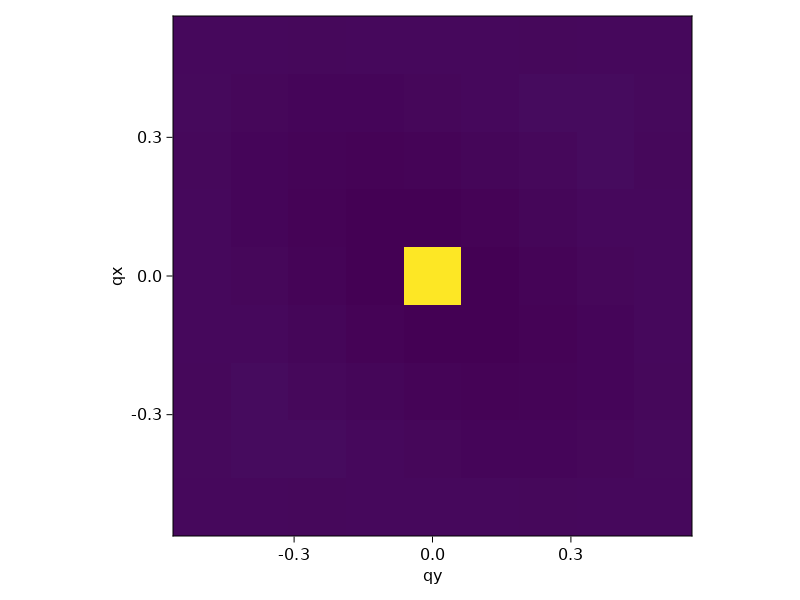

In [53]:
using CairoMakie, FileIO, Colors

fig = Figure(resolution = (800, 800))
ax = Axis(fig[1, 1])

c = HSV(250, 0.6, 1)

CairoMakie.heatmap(qx_map[:,1], qy_map[1,:], real(cdc_meas_fft),
    figure = (backgroundcolor = :white,),
    axis = (aspect = 1, xlabel = "qy", ylabel = "qx")
)
# 出现与文章对不上的结果，显然q=(0,0)的值太多，这是因为我们没有减去<n><n>的原因，即background

In [54]:
# 减去<n><n>，可以看作是扣背景

for m = 0:Lx-1, n = 0:Ly-1  # (m, n)表示两个site之间的矢量
    nn_00 = zero(Float64)
    for site1_x = 1:Lx, site1_y = 1:Ly # (site1_x, site1_y)表示site1的坐标
        site1 = double_lattice_array[site1_x, site1_y]
        site2 = double_lattice_array[site1_x + m, site1_y + n]
        
        nn_00 += occs_meas[site1] * occs_meas[site2]
    end
    nn_00 = nn_00 / dims
    cdc_meas[m+1, n+1] -= nn_00
end

display(cdc_meas)

8×8 Matrix{Float64}:
  0.533621    -0.0759001     0.000892338  …   0.000892338  -0.0759001
 -0.0765947   -0.0766935     0.00674117      -0.00588728    0.0074767
  0.001865     0.00624185    0.000725193      0.00103029   -0.00708375
  0.00149645  -0.00644873   -0.00579098       0.000290287   0.000372219
 -0.00618521  -0.000411664   0.00073888       0.00073888   -0.000411664
  0.00149645   0.000372219   0.000290287  …  -0.00579098   -0.00644873
  0.001865    -0.00708375    0.00103029       0.000725193   0.00624185
 -0.0765947    0.0074767    -0.00588728       0.00674117   -0.0766935

In [66]:
# 然后再做FFT
cdc_meas_fft = zeros(ComplexF64, (qx_points, qy_points))
for (qx_index, qx) in enumerate(qx_map[:,1]), (qy_index, qy) in enumerate(qy_map[1,:])
    for n1 = 0:Lx - 1, n2 = 0:Ly - 1
        phase_angle = 2 * pi * (qx * n1 + qy * n2)
        cdc_meas_fft[qx_index, qy_index] += exp(- im * phase_angle) * cdc_meas[n1 + 1, n2 + 1]
    end
end

# 必须算出来的结果是虚部为零才是对的
display(real(cdc_meas_fft))
display(cdc_meas_fft)
cdc_meas_fft[q_center[1],q_center[2]]

9×9 Matrix{Float64}:
 0.687986  0.697329  0.651547  0.692894  …  0.651547  0.697329  0.687986
 0.684553  0.823272  0.819088  0.690193     0.498293  0.591023  0.684553
 0.64131   0.817361  0.645614  0.504946     0.370226  0.499697  0.64131
 0.686623  0.68789   0.503456  0.341402     0.337077  0.499656  0.686623
 0.691391  0.594214  0.372078  0.190549     0.372078  0.594214  0.691391
 0.686623  0.499656  0.337077  0.187764  …  0.503456  0.68789   0.686623
 0.64131   0.499697  0.370226  0.33696      0.645614  0.817361  0.64131
 0.684553  0.591023  0.498293  0.497422     0.819088  0.823272  0.684553
 0.687986  0.697329  0.651547  0.692894     0.651547  0.697329  0.687986

9×9 Matrix{ComplexF64}:
 0.687986-9.88358e-17im  0.697329+2.77556e-16im  …  0.687986-2.85031e-18im
 0.684553-1.38778e-16im  0.823272-6.10623e-16im     0.684553-2.77556e-16im
  0.64131+4.44089e-16im  0.817361-2.35922e-16im      0.64131+5.68989e-16im
 0.686623-7.42462e-16im   0.68789-6.31436e-17im     0.686623-4.78784e-16im
 0.691391-1.52062e-16im  0.594214+6.17562e-16im     0.691391+1.52062e-16im
 0.686623+4.78784e-16im  0.499656+1.38778e-17im  …  0.686623+7.42462e-16im
  0.64131-5.68989e-16im  0.499697-4.71845e-16im      0.64131-4.44089e-16im
 0.684553+2.77556e-16im  0.591023-4.59702e-17im     0.684553+1.38778e-16im
 0.687986+2.85031e-18im  0.697329+1.73472e-16im     0.687986+9.88358e-17im

0.04268457022410993 + 0.0im

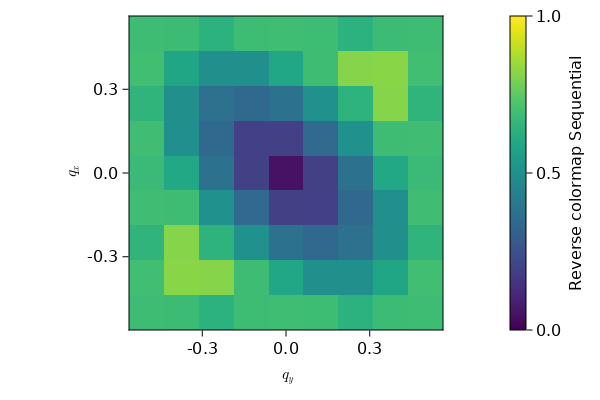

In [70]:
# CairoMakie.heatmap(qx_map[:,1], qy_map[1,:], real(cdc_meas_fft),
#     figure = (backgroundcolor = :white,),
#     axis = (aspect = 1, xlabel = "qy", ylabel = "qx")
# )

figure = (; resolution=(600, 400), font="CMU Serif")
axis = (; xlabel=L"q_y", ylabel=L"q_x", aspect=DataAspect())

# fig, ax, pltobj = CairoMakie.heatmap(qx_map[:,1], qy_map[1,:], real(cdc_meas_fft); 
#     colorrange=(0, 1), colormap=Reverse(:viridis), axis=axis, figure=figure)
fig, ax, pltobj = CairoMakie.heatmap(qx_map[:,1], qy_map[1,:], real(cdc_meas_fft); 
    colorrange=(0, 1), colormap=:viridis, axis=axis, figure=figure)
Colorbar(fig[1, 2], pltobj, label = "Reverse colormap Sequential")
fig

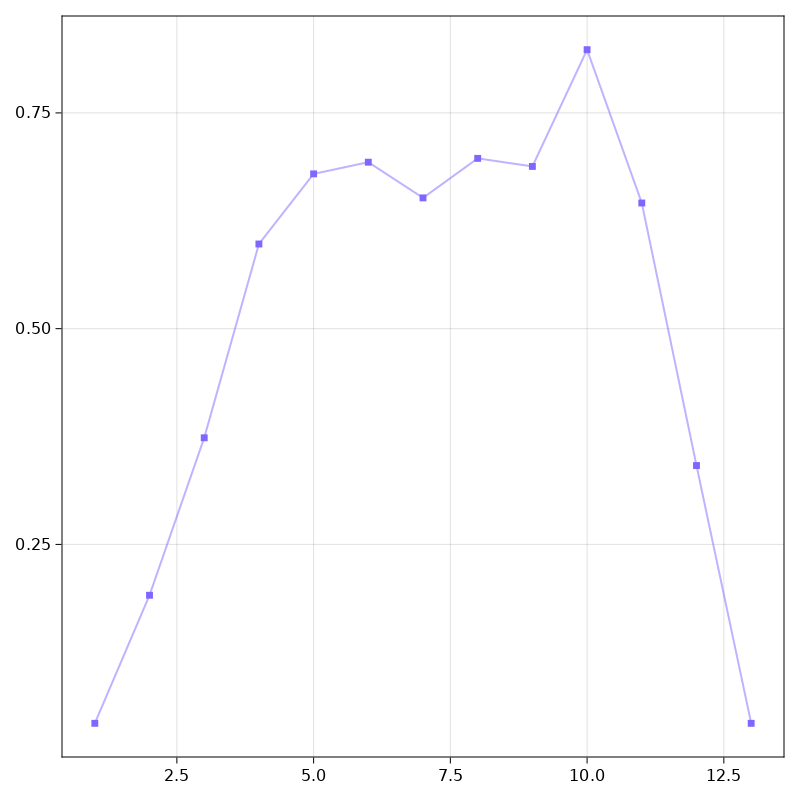

In [71]:
fig = Figure(resolution = (800, 800))
ax = Axis(fig[1, 1])

c = HSV(250, 0.6, 1)

line_cut = zeros(Float64, Int(3 * Lx / 2) + 1)

line_cut[1:q_center[1]] = real(cdc_meas_fft)[q_center[1]:qx_points, q_center[2]]
line_cut[(q_center[2] + 1):qy_points] = real(cdc_meas_fft)[qx_points, (q_center[2] + 1):qy_points]
for i = (qy_points - 1):-1:q_center[2]
    line_cut[2 * qy_points - i] = real(cdc_meas_fft)[i, i]
end

lines!(ax, line_cut, color = (c, 0.5), linewidth=2)
CairoMakie.scatter!(ax, line_cut, color = c, marker = '■')
# CairoMakie.scatter!(ax, line_cut, color = c, marker = 'o')

# x_lim设置

current_figure()